In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as pl

In [2]:
measurement_type = 'proj'
assert measurement_type in ['weak','proj'], print('measurement_type wrong')

setup = 'purification/with_scrambling'


In [7]:
root_direc = 'data_'+measurement_type+'_measurement/'+setup


In [8]:
print(os.listdir(root_direc))

['L=10', 'L=8', 'L=12']


In [267]:
def get_entropy(file):
    entropy = []
    for merged_file in os.listdir(file):
        with open(file+'/'+merged_file,'rb') as f:
            data = pickle.load(f)
            entropy.extend(data['entropy'])
    return entropy

def get_p(name:str):
    p = 0
    index2 = name.index('_BC')
    index1 = name.index('p=')
    p = float(name[index1+2:index2])
    return p

def get_g(name:str):
    g = 0
    index2 = name.index('_p=')
    index1 = name.index('g=')
    g = float(name[index1+2:index2])
    return g

def get_T(name:str):
    index = name.index('_tscr')
    T = int(name[2:index])
    return T

In [268]:
entropy_dic = {}
for L_file in os.listdir(root_direc):
    if 'L=' not in L_file:
        continue
    L = int(L_file[2:])
    entropy_dic[L] = {}
    sub_dir = root_direc + '/' + L_file
    for p_file in os.listdir(sub_dir):
        if 'p=' not in p_file:
            continue
        p = get_p(p_file)
        g = get_g(p_file)
        # checking correct T
        T = get_T(p_file)
        if T!=4*L:
            continue

        merged_dir = sub_dir + '/' + p_file + '/' + 'merged_files'
        entropy_dic[L][(g,p)] = np.array(get_entropy(merged_dir))
        # the shape of entropy_dic[L][p] is (N,T,A) where N is the number of samples, T is the time steps, and A is the total number of intervals considerd. If the last axis index is a, then a=0 corresponds to interval (L,L+L_A), a=1 to (L-1,L+L_A) and so on
    
    if len(entropy_dic[L]) == 0:
        entropy_dic.pop(L,None)

In [269]:
full_data = {}
for L in sorted(entropy_dic.keys()):
    full_data[L] = {}
    for gs,ps in sorted(entropy_dic[L].keys()):
        if gs not in full_data[L]: full_data[L][gs] = {}
        ancilla_ent_index = 0
        raw_data = entropy_dic[L][(gs,ps)][:,:,ancilla_ent_index]
        full_data[L][gs][ps] = raw_data
           

### S vs t for various L and fixed p,g

8 1000 32 0.15 0.3
10 1000 40 0.15 0.3
12 1000 48 0.15 0.3
14 1000 56 0.15 0.3


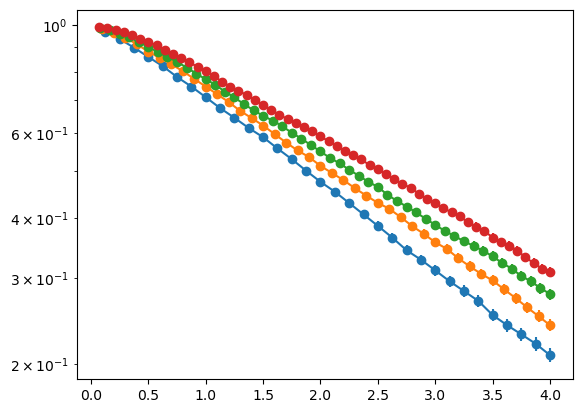

In [298]:
p_fixed = 0.15
g_fixed = 0.3

for L in sorted(full_data.keys()):

    try: data = full_data[L][g_fixed][p_fixed]
    except: continue
    T = data.shape[1]
    N = data.shape[0]
    print(L,N,T,p_fixed,g_fixed)

        
    xdata = np.arange(1,T+1,1)
    ydata = np.sum(data,axis=0)/N
    yerr = np.std(data,axis=0)/(N-1)**0.5

    # ydata = (ydata[::2]+ydata[1::2])*0.5
    # yerr = (yerr[::2] + yerr[1::2])*0.5
    # xdata = xdata[::2]

    pl.errorbar(xdata/L,ydata,yerr=yerr,ls='-',marker='o')

pl.yscale('log')

### S vs p for various L and fixed g

8 [0.05 0.15 0.2  0.25 0.3  0.35 0.4 ] 0.3
10 [0.05 0.15 0.2  0.25 0.3  0.35 0.4 ] 0.3
12 [0.05 0.15 0.2  0.25 0.3  0.35 0.4 ] 0.3
14 [0.05 0.15 0.2  0.25 0.3  0.35 0.4 ] 0.3


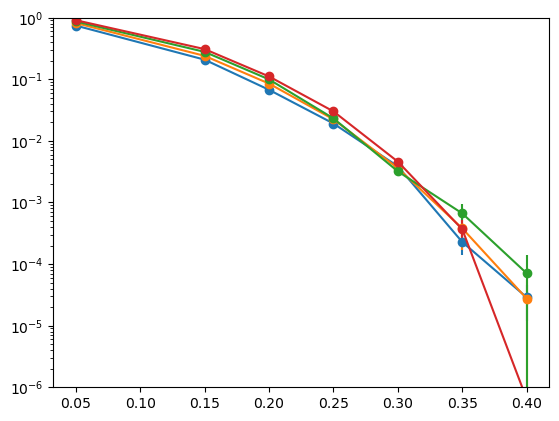

In [287]:
g_fixed = 0.3

for L in sorted(full_data.keys()):

    try: data = full_data[L][g_fixed]
    except: continue
    xdata = np.array(list(sorted(data.keys())))
   
    print(L,xdata,g_fixed)

    ydata = np.array([np.average(data[p][:,-1:].flatten()) for p in xdata])
    yerr = np.array([np.std(data[p][:,-1:].flatten())/(data[p].shape[0]-1)**0.5 for p in xdata])
    
    pl.errorbar(xdata,ydata,yerr=yerr,ls='-',marker='o')

pl.ylim(1e-6,1)
pl.yscale('log')

### S vs g for various L and fixed p

8 [0.  0.1 0.3 0.5 0.6 0.7 0.8 1. ] 0.3
10 [0.  0.1 0.3 0.5 0.6 0.7 0.8 1. ] 0.3
12 [0.  0.1 0.3 0.5 0.6 0.7 0.8 1. ] 0.3
14 [0.1 0.3 0.5 0.6 0.7 0.8] 0.3


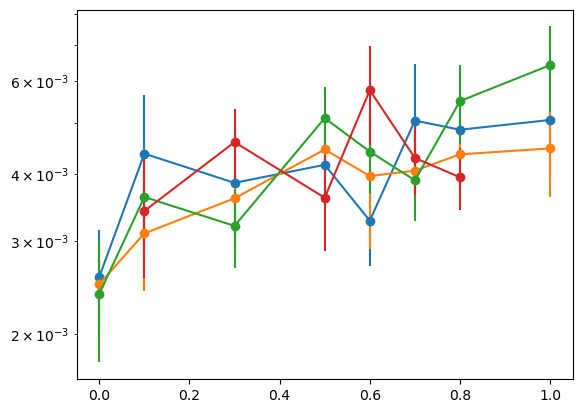

In [290]:
p_fixed = 0.3

for L in sorted(full_data.keys()):

    data = full_data[L]
    xdata = np.array([g for g in list(sorted(data.keys())) if p_fixed in data[g]])
    
    print(L,xdata,p_fixed)


    ydata = np.array([np.average(data[g][p_fixed][:,-1:].flatten()) for g in xdata])
    yerr = np.array([np.std(data[g][p_fixed][:,-1:].flatten())/(data[g][p_fixed].shape[0]-1)**0.5 for g in xdata])
    
    
    pl.errorbar(xdata,ydata,yerr=yerr,ls='-',marker='o')

pl.yscale('log')